In [1]:
from __future__ import division, print_function, unicode_literals, absolute_import

import numpy as np
import brainstorm as bs
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

No module named pycuda


In [2]:
def normalize(data):
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    return (data - means) / stds, means, stds

In [3]:
ds = h5py.File('simdata2.hdf5', 'r')

## Get a Network

In [4]:
from train_net import ex, build_network

Here we'll use the standard configuration from the train_net file.  If you changed something about the network you need to add it into config_updates here like that:
  
    config_updates={'num_layers': 3}


In [5]:
run = ex._create_run_for_command("print_config", config_updates={}, named_configs_to_use={})

We'll load the weights from the file `best_weights.npy`:

In [7]:
weights = np.load('best_weights.npy')
net = build_network()
net.buffer.forward.parameters[:] = weights

## Run on the dataset
Now we'll run that network on the whole dataset and look at how much of the total error comes from each sample

### training data

In [8]:
net.provide_external_data(ds['training'])
net.forward_pass()
all_losses = net.buffer.forward.SquaredDifferenceLayer.outputs.default
all_losses.shape

(1, 899957, 1)

In [9]:
# Sort by loss
sort_idxs = np.argsort(all_losses.flatten())
all_losses = np.sqrt(all_losses[0, sort_idxs, 0])
targets = net.buffer.forward.SquaredDifferenceLayer.inputs.inputs_2[0, sort_idxs, 0]
outputs = net.buffer.forward.SquaredDifferenceLayer.inputs.inputs_1[0, sort_idxs, 0]
inputs = net.buffer.forward.InputLayer.outputs.input_data[0, sort_idxs, :]

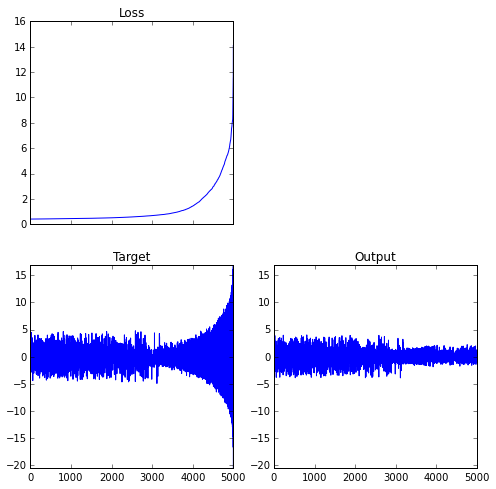

In [10]:
subset = slice(-5000, None)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True)
lim = np.min(targets[subset]), np.max(targets[subset])
axes[0, 0].plot(all_losses[subset])
axes[0, 0].set_title('Loss')
axes[1, 0].plot(targets[subset])
axes[1, 0].set_ylim(*lim)
axes[1, 0].set_title('Target')
axes[1, 1].plot(outputs[subset])
axes[1, 1].set_ylim(*lim)
axes[1, 1].set_title('Output')
axes[0, 1].set_visible(False)


Wow it seems most of the error comes from the last 1500-2000 samples. The ANN can not make sense of those, so I'll remove them.

In [11]:
new_train_data = inputs[:-1600]
new_train_targets = targets[:-1600]
idxs = np.arange(new_train_data.shape[0])
np.random.shuffle(idxs)
new_train_data = new_train_data[idxs].reshape(1, -1, 8)
new_train_targets = new_train_targets[idxs].reshape(1, -1, 1)

new_train_data, means, stds = normalize(new_train_data)
new_train_targets, tmeans, tstds = normalize(new_train_targets)

In [12]:
new_train_data.shape

(1, 898357, 8)

In [13]:
new_train_targets.shape

(1, 898357, 1)

### validation

In [14]:
net.provide_external_data(ds['validation'])
net.forward_pass()
all_losses = net.buffer.forward.SquaredDifferenceLayer.outputs.default
all_losses.shape

(1, 99995, 1)

In [15]:
sort_idxs = np.argsort(all_losses.flatten())

In [16]:
all_losses = np.sqrt(all_losses[0, sort_idxs, 0])
targets = net.buffer.forward.SquaredDifferenceLayer.inputs.inputs_2[0, sort_idxs, 0]
outputs = net.buffer.forward.SquaredDifferenceLayer.inputs.inputs_1[0, sort_idxs, 0]
inputs = net.buffer.forward.InputLayer.outputs.input_data[0, sort_idxs, :]

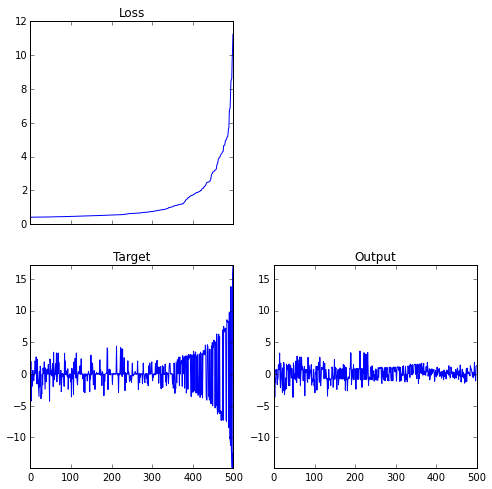

In [17]:
subset = slice(-500, None)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True)
lim = np.min(targets[subset]), np.max(targets[subset])
axes[0, 0].plot(all_losses[subset])
axes[0, 0].set_title('Loss')
axes[1, 0].plot(targets[subset])
axes[1, 0].set_ylim(*lim)
axes[1, 0].set_title('Target')
axes[1, 1].plot(outputs[subset])
axes[1, 1].set_ylim(*lim)
axes[1, 1].set_title('Output')
axes[0, 1].set_visible(False)

In [18]:
new_val_data = inputs[:-200]
new_val_targets = targets[:-200]
idxs = np.arange(new_val_data.shape[0])
np.random.shuffle(idxs)
new_val_data = new_val_data[idxs].reshape(1, -1, 8)
new_val_targets = new_val_targets[idxs].reshape(1, -1, 1)

new_val_data = (new_val_data - means) / stds
new_val_targets = (new_val_targets - tmeans) / tstds

In [19]:
new_val_targets.shape

(1, 99795, 1)

## Create a new cleaned dataset

In [52]:
with h5py.File('simdata2_cleaned.hdf5', 'w') as f:
    f['training/input_data'] = new_train_data
    f['training/input_data'].attrs['means'] = means
    f['training/input_data'].attrs['stds'] = stds
    f['training/targets'] = new_train_targets
    f['training/targets'].attrs['means'] = tmeans
    f['training/targets'].attrs['means'] = tstds

    f['validation/input_data'] = new_val_data
    f['validation/input_data'].attrs['means'] = means
    f['validation/input_data'].attrs['stds'] = stds
    f['validation/targets'] = new_val_targets
    f['validation/targets'].attrs['means'] = tmeans
    f['validation/targets'].attrs['means'] = tstds